## Convolutional Neural Network (CNN) with TensorFlow

CNN is a type of architecture in deep learning. Unlike simple deep learning where every layer is fully connected each other, there is sort of selective mechanism. This mechanism can happen thanks to special strcucture named as convolutional layer. Neurons in the first convolutional layer is connected only to pixels in their receptive fields.

<img src='./images/cnn_1.png' style='width: 500px' align='left'/>


<img src='./images/cnn_2c.png' style='width: 500px' align='left'/>

<img src='./images/cnn_1a.png' style='width: 500px' align='left'/>


In the implementation, usually the filter is applied to produce several feature maps at once. In a sense, we can imagine that these feature maps try to capture different properties of the image, like horizontal line, edges, vertical lines, etc.

<img src='./images/cnn_2.png' style='width: 500px' align='left'/>


<img src='./images/cnn_1b.png' style='width: 500px' align='left'/>


<img src='./images/cnn_1c.png' style='width: 500px' align='left'/>


A closer look on convolutional layer with more than 1 output.

<img src='./images/cnn_2a.png' style='width: 500px' align='left'/>


<img src='./images/cnn_2b.png' style='width: 500px' align='left'/>


In addition to convolutional layer, there is also pooling layer in CNN. Intuitively speaking, this layer creates a more compact information.

<img src='./images/cnn_3a.png' style='width: 500px' align='left'/>


<img src='./images/cnn_3b.png' style='width: 500px' align='left'/>


Usually, if we intend to use CNN for classification, there is also fully connected layer. This layer should remind us with the ordinary neural network where every weight is connected to its input (instead of just looking at a particular region of the images like convolutional layer or pooling layer).

<img src='./images/cnn_3.png' style='width: 500px' align='left'/>


In conclusion, there are three basic layers in CNN architecture: convolutional layer, pooling layer, and fully connected layer. Different combination of these basic layers can lead to different result in images classification. In the following section, we will observe the implementation of two early CNN architectures. Nevertheless, we should note that these examples are presented to give rough idea on how we can use TensorFlow to build CNN architecture in images classification. There are many other CNN architecture out there with tweaks and modification in its layers - that allows much better performance.

### FIRST TRIAL: LE-NET

<img src='./images/lenet.png' style='width: 500px' align='left'/>


<img src='./images/lenet_table.png' style='width: 500px' align='left'/>


In [2]:
from __future__ import division, print_function, absolute_import
import tensorflow as tf
import numpy as np

In [17]:
import matplotlib.pyplot as plt


In [30]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('data/fashion', one_hot = True)




Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz


In [31]:
%matplotlib inline

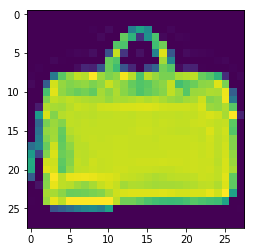

In [38]:
plt.imshow(mnist.train.images[100, :].reshape(28, 28))

In [33]:
mnist.train.images.shape

(55000, 784)

In [34]:
# Training Parameters
learning_rate = 0.001
num_steps = 500
batch_size = 128
display_step = 10

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units

# tf Graph input
X = tf.placeholder(tf.float32, [None, num_input])
Y = tf.placeholder(tf.float32, [None, num_classes])
keep_prob = tf.placeholder(tf.float32) # dropout (keep probability)

In [11]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
    # Reshape to match picture format [Height x Width x Channel]
    # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [35]:
# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, num_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

# Construct model
logits = conv_net(X, weights, biases, keep_prob)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)


# Evaluate model
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [36]:
# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for step in range(1, num_steps+1):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, keep_prob: dropout})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y,
                                                                 keep_prob: 1.0})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))

    print("Optimization Finished!")

    # Calculate accuracy for 256 MNIST test images
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: mnist.test.images[:256],
                                      Y: mnist.test.labels[:256],
                                      keep_prob: 1.0}))

Step 1, Minibatch Loss= 49078.7344, Training Accuracy= 0.242
Step 10, Minibatch Loss= 14592.0947, Training Accuracy= 0.414
Step 20, Minibatch Loss= 10851.8115, Training Accuracy= 0.516
Step 30, Minibatch Loss= 7342.7041, Training Accuracy= 0.656
Step 40, Minibatch Loss= 4198.0322, Training Accuracy= 0.719
Step 50, Minibatch Loss= 5287.4971, Training Accuracy= 0.734
Step 60, Minibatch Loss= 7388.8906, Training Accuracy= 0.688
Step 70, Minibatch Loss= 4676.9697, Training Accuracy= 0.766
Step 80, Minibatch Loss= 3998.1355, Training Accuracy= 0.758
Step 90, Minibatch Loss= 5508.6729, Training Accuracy= 0.773
Step 100, Minibatch Loss= 2534.5591, Training Accuracy= 0.789
Step 110, Minibatch Loss= 2641.8672, Training Accuracy= 0.805
Step 120, Minibatch Loss= 4387.5078, Training Accuracy= 0.781
Step 130, Minibatch Loss= 5260.2881, Training Accuracy= 0.688
Step 140, Minibatch Loss= 4381.7178, Training Accuracy= 0.758
Step 150, Minibatch Loss= 1163.1853, Training Accuracy= 0.867
Step 160, Miniba

#### SECOND TRIAL: ALEX-NET

<img src='./images/alexnet.png' style='width: 1000px' align='left'/>


<img src='./images/alexnet_table.png' style='width: 500px' align='left'/>


In [40]:
learning_rate = 0.001
training_iters = 200000
batch_size = 64
display_step = 20

In [41]:
# Network Parameters
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.8 # Dropout, probability to keep units

In [44]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) # dropout (keep probability)

In [48]:
# Create AlexNet model
def conv2d(name, l_input, w, b):
    return tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(l_input, w, strides=[1, 1, 1, 1], padding='SAME'),b), name=name)

def max_pool(name, l_input, k):
    return tf.nn.max_pool(l_input, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME', name=name)

def norm(name, l_input, lsize=4):
    return tf.nn.lrn(l_input, lsize, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name=name)

def alex_net(_X, _weights, _biases, _dropout):
    # Reshape input picture
    _X = tf.reshape(_X, shape=[-1, 28, 28, 1])
    
        # Convolution Layer
    conv1 = conv2d('conv1', _X, _weights['wc1'], _biases['bc1'])
    # Max Pooling (down-sampling)
    pool1 = max_pool('pool1', conv1, k=2)
    # Apply Normalization
    norm1 = norm('norm1', pool1, lsize=4)
    # Apply Dropout
    norm1 = tf.nn.dropout(norm1, _dropout)

    # Convolution Layer
    conv2 = conv2d('conv2', norm1, _weights['wc2'], _biases['bc2'])
    # Max Pooling (down-sampling)
    pool2 = max_pool('pool2', conv2, k=2)
    # Apply Normalization
    norm2 = norm('norm2', pool2, lsize=4)
    # Apply Dropout
    norm2 = tf.nn.dropout(norm2, _dropout)

    # Convolution Layer
    conv3 = conv2d('conv3', norm2, _weights['wc3'], _biases['bc3'])
    # Max Pooling (down-sampling)
    pool3 = max_pool('pool3', conv3, k=2)
    # Apply Normalization
    norm3 = norm('norm3', pool3, lsize=4)
    # Apply Dropout
    norm3 = tf.nn.dropout(norm3, _dropout)

    # Fully connected layer
    dense1 = tf.reshape(norm3, [-1, _weights['wd1'].get_shape().as_list()[0]]) # Reshape conv3 output to fit dense layer input
    dense1 = tf.nn.relu(tf.matmul(dense1, _weights['wd1']) + _biases['bd1'], name='fc1') # Relu activation

    dense2 = tf.nn.relu(tf.matmul(dense1, _weights['wd2']) + _biases['bd2'], name='fc2') # Relu activation

    # Output, class prediction
    out = tf.matmul(dense2, _weights['out']) + _biases['out']
    return out

In [49]:

# Store layers weight & bias
weights = {
    'wc1': tf.Variable(tf.random_normal([3, 3, 1, 64])),
    'wc2': tf.Variable(tf.random_normal([3, 3, 64, 128])),
    'wc3': tf.Variable(tf.random_normal([3, 3, 128, 256])),
    'wd1': tf.Variable(tf.random_normal([4*4*256, 1024])),
    'wd2': tf.Variable(tf.random_normal([1024, 1024])),
    'out': tf.Variable(tf.random_normal([1024, 10]))
}
biases = {
    'bc1': tf.Variable(tf.random_normal([64])),
    'bc2': tf.Variable(tf.random_normal([128])),
    'bc3': tf.Variable(tf.random_normal([256])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'bd2': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [53]:

# Construct model
pred = alex_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred, labels = y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [61]:

# Initializing the variables
init = tf.global_variables_initializer()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        # Fit training using batch data
        sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})
        #if step % display_step == 0:
            # Calculate batch accuracy
        acc = sess.run(accuracy, feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.})
            # Calculate batch loss
        loss = sess.run(cost, feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.})
        print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + "{:.6f}".format(loss) + ", Training Accuracy= " + "{:.5f}".format(acc))
        step += 1
    print("Optimization Finished!")
    # Calculate accuracy for 256 mnist test images
    print("Testing Accuracy:", sess.run(accuracy, feed_dict={x: mnist.test.images[:256], y: mnist.test.labels[:256], keep_prob: 1.}))


Iter 64, Minibatch Loss= 331836.437500, Training Accuracy= 0.09375
Iter 128, Minibatch Loss= 219700.031250, Training Accuracy= 0.12500
Iter 192, Minibatch Loss= 183833.218750, Training Accuracy= 0.12500
Iter 256, Minibatch Loss= 190779.093750, Training Accuracy= 0.18750
Iter 320, Minibatch Loss= 152620.343750, Training Accuracy= 0.21875
Iter 384, Minibatch Loss= 217480.343750, Training Accuracy= 0.06250
Iter 448, Minibatch Loss= 160081.812500, Training Accuracy= 0.18750
Iter 512, Minibatch Loss= 203565.515625, Training Accuracy= 0.09375
Iter 576, Minibatch Loss= 160180.843750, Training Accuracy= 0.20312
Iter 640, Minibatch Loss= 190081.218750, Training Accuracy= 0.17188
Iter 704, Minibatch Loss= 166249.906250, Training Accuracy= 0.06250
Iter 768, Minibatch Loss= 123140.734375, Training Accuracy= 0.20312
Iter 832, Minibatch Loss= 107390.593750, Training Accuracy= 0.15625
Iter 896, Minibatch Loss= 98538.312500, Training Accuracy= 0.26562
Iter 960, Minibatch Loss= 116233.820312, Training 

### REFERENCE

https://github.com/aymericdamien/TensorFlow-Examples

http://cs231n.stanford.edu/

http://shop.oreilly.com/product/0636920052289.do

